Feature Engineering
Project: Daily Precipitation Prediction – Miami (Open-Meteo)

Objective / Objetivo
EN: Define and construct physically-motivated features for daily precipitation modeling.
ES: Definir y construir variables predictoras con criterio físico para el modelado de precipitación diaria.

In [241]:
# --- Notebook setup (DO NOT REMOVE) ---
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.features import RAW_COLUMNS
from src.features import build_base_features


In [242]:
#2 - Load cleaned daily dataset
DATA_PATH = "../data/raw/open_meteo_miami_daily.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)
df = df.rename(columns=RAW_COLUMNS)
df = build_base_features(df)
df.head()

,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,rain_sum,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant,sunrise,sunset,shortwave_radiation_sum,weather_code,date,temp_range
0,1990-01-01,27.4,22.2,24.0,0.0,0.0,0.0,16.1,200,1990-01-01T12:07,1990-01-01T22:41,13.68,1,1990-01-01,5.2
1,1990-01-02,24.4,20.5,21.8,0.0,0.0,0.0,31.6,45,1990-01-02T12:07,1990-01-02T22:41,9.24,3,1990-01-02,3.9
2,1990-01-03,24.4,21.0,22.3,0.1,0.1,1.0,25.3,71,1990-01-03T12:08,1990-01-03T22:42,10.07,51,1990-01-03,3.4
3,1990-01-04,25.3,23.0,23.9,0.7,0.7,5.0,27.3,94,1990-01-04T12:08,1990-01-04T22:43,11.41,51,1990-01-04,2.3
4,1990-01-05,25.9,23.3,24.2,0.7,0.7,6.0,24.4,115,1990-01-05T12:08,1990-01-05T22:44,12.83,51,1990-01-05,2.6


In [243]:
#3- Target definition
y = df["precipitation_sum"]


EN: Daily total precipitation in millimeters.

ES: Precipitación total diaria en milímetros.

In [244]:
#4 - Base physical features
# Temperature-based features
df["temp_range"] = df["temperature_2m_max"] - df["temperature_2m_min"]

Physical motivation / Motivación física
EN: Temperature range is a proxy for atmospheric instability.
ES: El rango térmico es un proxy de inestabilidad atmosférica.

In [245]:
#5 - Calendar features
df["month"] = df["date"].dt.month
df["dayofyear"] = df["date"].dt.dayofyear

EN: Captures seasonal forcing.
ES: Captura la estacionalidad anual.

In [246]:
#6 - Lag features (atmospheric memory)
# Precipitation lags
df["precip_lag_1"] = df["precipitation_sum"].shift(1)
df["precip_lag_3"] = df["precipitation_sum"].shift(3)
df["precip_lag_7"] = df["precipitation_sum"].shift(7)

EN: Weather systems often persist for several days.
ES: Los sistemas meteorológicos suelen persistir varios días.

In [247]:
#7 - Rolling window features
df["precip_roll_3"] = df["precipitation_sum"].rolling(3).mean()
df["precip_roll_7"] = df["precipitation_sum"].rolling(7).mean()

EN: Smooths short-term variability and captures trends.
ES: Suaviza la variabilidad de corto plazo y captura tendencias.

In [250]:
print(sorted(df.columns))
print(len(df), df.shape)

['date', 'dayofyear', 'month', 'precip_lag_1', 'precip_lag_3', 'precip_lag_7', 'precip_roll_3', 'precip_roll_7', 'precipitation_hours', 'precipitation_sum', 'rain_sum', 'shortwave_radiation_sum', 'sunrise', 'sunset', 'temp_range', 'temperature_2m_max', 'temperature_2m_mean', 'temperature_2m_min', 'time', 'weather_code', 'wind_direction_10m_dominant', 'wind_speed_10m_max']
12784 (12784, 22)


In [251]:
print(sorted(df.columns))

['date', 'dayofyear', 'month', 'precip_lag_1', 'precip_lag_3', 'precip_lag_7', 'precip_roll_3', 'precip_roll_7', 'precipitation_hours', 'precipitation_sum', 'rain_sum', 'shortwave_radiation_sum', 'sunrise', 'sunset', 'temp_range', 'temperature_2m_max', 'temperature_2m_mean', 'temperature_2m_min', 'time', 'weather_code', 'wind_direction_10m_dominant', 'wind_speed_10m_max']


In [ ]:
#8 - Feature selection (initial set)
feature_cols = [
"temperature_2m_mean",
"temp_range",
"relative_humidity_2m_mean",
"cloud_cover_mean",
"surface_pressure_mean",
"wind_speed_10m_mean",
"month",
"dayofyear",
"precip_lag_1",
"precip_lag_3",
"precip_lag_7",
"precip_roll_3",
"precip_roll_7"
]

feature_cols = [
    "temperature_2m_mean",
    "temp_range",
    "wind_speed_10m_max",
    "month",
    "dayofyear",
    "precip_lag_1",
    "precip_lag_3",
    "precip_lag_7",
    "precip_roll_3",
    "precip_roll_7",
]


X = df[feature_cols]

KeyError: "['relative_humidity_2m_mean', 'cloud_cover_mean', 'surface_pressure_mean', 'wind_speed_10m_mean'] not in index"

In [ ]:
#9 - Handle missing values from lags
model_df = pd.concat([X, y], axis=1).dropna()


X_model = model_df[feature_cols]
y_model = model_df["precipitation_sum"]

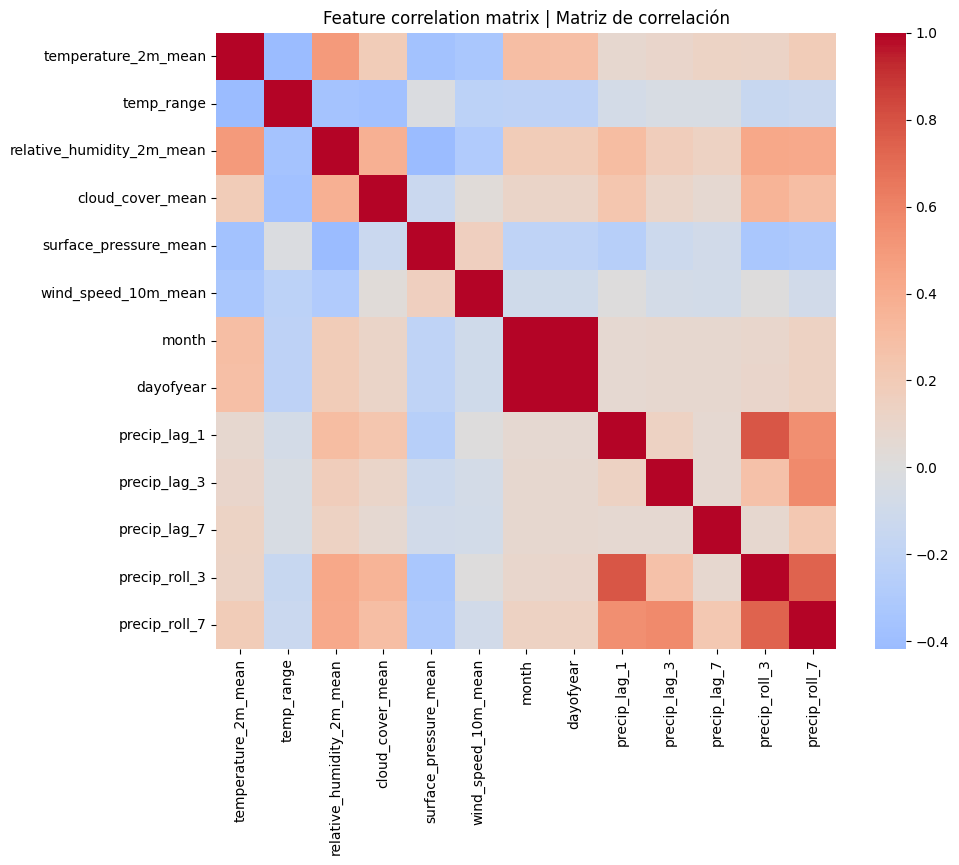

In [ ]:
#10 - Feature correction check
plt.figure(figsize=(10,8))
sns.heatmap(X_model.corr(), cmap="coolwarm", center=0)
plt.title("Feature correlation matrix | Matriz de correlación")
plt.show()

11. Final notes / Notas finales

EN: All features are physically interpretable.

ES: Todas las variables tienen interpretación física.

EN: Feature redundancy will be addressed during modeling.

ES: La redundancia se evaluará durante el modelado.